In [213]:
# Imports Libs for:

# Web scraping
import requests
from bs4 import BeautifulSoup
from myfuncs import * # Self-defined functions for pulling data from specific sites
from dotenv import load_dotenv
import os

# Data analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score #, calinski_harabasz_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopandas as gpd

# Set random seed
np.random.seed(42)


# Data Extraction & Preprocessing

## State-level Data

### FRED API

In [2]:
url = 'https://fred.stlouisfed.org/release/tables?rid=249&eid=259462' # Median household income by state
variable = 'Median Household Income'

income_df = extract_FRED_data(url,variable)
income_df.head()

,State Name,Median Household Income [Current Dollars],Year
0,The United States,80610.0,2023
1,Alabama,60660.0,2023
2,Alaska,98190.0,2023
3,Arizona,82660.0,2023
4,Arkansas,63250.0,2023


In [3]:
url = 'https://fred.stlouisfed.org/release/tables?eid=840687&rid=116'
variable = 'Unemployment Rate'
UE_df = extract_FRED_data(url,variable)
UE_df.head()

,State Name,Unemployment Rate [Percent],Year
0,Alabama,2.5,2023
1,Alaska,4.2,2023
2,Arizona,3.9,2023
3,Arkansas,3.3,2023
4,California,4.8,2023


In [4]:
url = 'https://fred.stlouisfed.org/release/tables?eid=259194&rid=118'
variable = 'Population'
pop_df = extract_FRED_data(url,variable)
pop_df.head()

,State Name,Population [Thousands of Persons],Year
0,Alabama,5108.468,2023
1,Alaska,733.406,2023
2,Arizona,7431.344,2023
3,Arkansas,3067.732,2023
4,California,38965.193,2023


In [17]:
# Compile FRED data: income_df, UE_df, pop_df

fred_df = pd.merge(income_df, UE_df, on=['State Name', 'Year'], how='inner') \
           .merge(pop_df, on=['State Name', 'Year'], how='inner')
# fred_df.to_csv('assets/FRED_data.csv', index=None)
# fred_df = pd.read_csv('assets/FRED_data.csv')
fred_df.head()

,State Name,Median Household Income [Current Dollars],Year,Unemployment Rate [Percent],Population [Thousands of Persons]
0,Alabama,60660.0,2023,2.5,5108.468
1,Alaska,98190.0,2023,4.2,733.406
2,Arizona,82660.0,2023,3.9,7431.344
3,Arkansas,63250.0,2023,3.3,3067.732
4,California,89870.0,2023,4.8,38965.193


### US Census Bureau: American Community Survey (ACS)

In [214]:
api_key_USCB = os.getenv('API_KEY_USCB')

acs_2023_df = extract_and_preprocess_ACS_data(api_key=api_key_USCB, year=2023, state_code=None)
acs_2022_df =  extract_and_preprocess_ACS_data(api_key=api_key_USCB, year=2022, state_code=None)

In [265]:
acs_df = pd.concat([acs_2023_df,acs_2022_df],ignore_index=True)
acs_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065


In [266]:
acs_df.Year.unique()

array([2023, 2022])

### State Information

In [267]:
# Map state FIPS code to state names

state_df = extract_state_mapper()
state_df.to_csv('assets/state_info.csv', index=None)
# state_df = pd.read_csv('assets/state_info.csv')
state_df.head()

,State Name,State Code (FIPS),State Code (USPS)
0,Alabama,01,AL
1,Alaska,02,AK
2,Arizona,04,AZ
3,Arkansas,05,AR
4,California,06,CA


In [268]:
# Merge state name to acs_df based on FIPS code
acs_df= pd.merge(acs_df, state_df, on = 'State Code (FIPS)', how = 'left').dropna()
acs_df.to_csv('assets/acs_df.csv',index=None)
# acs_df = pd.read_csv('assets/acs_df.csv')
acs_df.head()

,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Name,State Code (USPS)
0,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,Alabama,AL
1,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,Alaska,AK
2,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,Arizona,AZ
3,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,Arkansas,AR
4,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,California,CA


### Air Travel Data

In [269]:
# Domestic flight by origin airports (2023)
# Data: Flight volume by Airport Code; this will be our main dataset
# Extraction: csv download from https://equity-data.dot.gov/datasets/17e9a793c7cf47c8b64dab92da55dfe5/about

fp_flights = 'assets/T100_Domestic_Market_and_Segment_Data_-3591723781169319541.csv'
flight_df = pd.read_csv(fp_flights)
flight_df.columns = flight_df.columns.str.title()
flight_df.rename(columns={'Origin': 'Airport Code'}, inplace=True)
flight_df.head() # Here, origin airport names ('origin') are abbreviated by the respective Airport Codes.

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334


In [270]:
# Map airports to their respective states based on Airport Code
df_airports = extract_airport_info()
df_airports.head()

,Airport Code,Airport Name,City,State Code (USPS)
0,ABE,Lehigh Valley International,Allentown,PA
1,ABI,Abilene Regional,Abilene,TX
2,ABQ,Albuquerque International,Albuquerque,NM
3,ACK,Nantucket Memorial,Nantucket,MA
4,ADQ,Kodiak,Kodiak,AK


In [271]:
# df_airports['Airport Code'].unique() # ok
# df_airports['State Code (USPS)'].unique() # contain trailing whitespaces
df_airports['State Code (USPS)'] = df_airports['State Code (USPS)'].str.strip()
df_airports['State Code (USPS)'].unique() 

array(['PA', 'TX', 'NM', 'MA', 'AK', 'GA', 'NY', 'IA', 'WI', 'NC', 'MI',
       'CT', 'CA', 'ME', 'AL', 'MT', 'ND', 'TN', 'ID', 'PR', 'LA', 'VT',
       'MD', 'SC', 'OH', 'CO', 'WV', 'FL', 'DC', 'MN', 'OR', 'IN', 'NJ',
       'SD', 'WA', 'MS', None, 'Oahu, HI', 'KS', 'Hawaii, HI', 'WY', 'NV',
       'KY', 'HI', 'AR', 'NE', 'MO', 'IL', 'NH', 'OK', 'VA', 'AZ', 'RI',
       'UT', 'Mariana Islands', 'VI'], dtype=object)

In [272]:
# Add state info (State Code (USPS)) to flight_df
flight_df = pd.merge(flight_df,df_airports, on='Airport Code', how='left').dropna()
flight_df.head()

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS)
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732,Hartsfield International,Atlanta,GA
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972,Denver International,Denver,CO
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642,Dallas/Ft.Worth International,Dallas/Ft. Worth,TX
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924,Chicago O'Hare International,Chicago,IL
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334,McCarran International,Las Vegas,NV


In [273]:
flight_df[flight_df.isna().any(axis=1)] 

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS)


In [274]:
# Add complete state-level info to flight_df 
flight_df = pd.merge(flight_df, state_df, on="State Code (USPS)", how='left')
flight_df.head()

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732,Hartsfield International,Atlanta,GA,Georgia,13
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972,Denver International,Denver,CO,Colorado,08
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642,Dallas/Ft.Worth International,Dallas/Ft. Worth,TX,Texas,48
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924,Chicago O'Hare International,Chicago,IL,Illinois,17
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334,McCarran International,Las Vegas,NV,Nevada,32


In [275]:
flight_df[flight_df.isna().any(axis=1)] #some rows failed to merge based on state code

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
29,30,2023,HNL,8683570,8712287,84008,84342.0,403171072,48837780,Honolulu International,Honolulu,"Oahu, HI",NaN,NaN
41,42,2023,SJU,5356377,5369531,46433,45366.0,132448723,5717439,Luis Munoz Marin International,San Juan,PR,NaN,NaN
70,71,2023,KOA,2055155,2061662,21244,21311.0,41430534,1187629,Kona International at Ke-Ahole,Kona,"Hawaii, HI",NaN,NaN
103,110,2023,STT,701396,701405,13923,14620.0,275691,0,Cyril E. King,St. Thomas,VI,NaN,NaN
106,113,2023,ITO,684175,684329,9109,9123.0,13325009,2,General Lyman Field,Hilo,"Hawaii, HI",NaN,NaN
133,143,2023,BQN,425461,425461,3180,3413.0,18285407,0,Rafael Hernandez,Aguadilla,PR,NaN,NaN
162,181,2023,STX,235368,235538,8806,8932.0,121732,0,Henry E. Rholsen,St. Croix,VI,NaN,NaN
197,246,2023,SPN,73233,73233,12353,12209.0,1174097,0,Saipan International,Saipan,Mariana Islands,NaN,NaN


In [276]:
flight_na = flight_df[flight_df.isna().any(axis=1)] 
flight_na['State Code (USPS)'].unique()

array(['Oahu, HI', 'PR', 'Hawaii, HI', 'VI', 'Mariana Islands'],
      dtype=object)

In [277]:
hawaii_state_info = state_df[state_df['State Code (USPS)'] == 'HI']
hawaii_FIPS = hawaii_state_info['State Code (FIPS)'].values[0]
hawaii_USPS = hawaii_state_info['State Code (FIPS)'].values[0]
hawaii_state_name = hawaii_state_info['State Code (FIPS)'].values[0]

hawaii_state_info

,State Name,State Code (FIPS),State Code (USPS)
11,Hawaii,15,HI


In [278]:
# Only Hawaii is a state. Mariana Islands, Puerto Rico (PR) and the U.S. Virgin Islands (VI) are not considered states in the United States
# Perform correction for Hawaii
flight_df.loc[flight_df['State Code (USPS)'].str.contains('HI'), ['State Code (USPS)', 'State Code (FIPS)', 'State Name']] = ['HI', 15, 'Hawaii']
flight_df[flight_df['State Code (USPS)'] == 'Hawaii, HI']

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)


In [279]:
flight_df[flight_df['State Code (USPS)'] == 'HI']

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
29,30,2023,HNL,8683570,8712287,84008,84342.0,403171072,48837780,Honolulu International,Honolulu,HI,Hawaii,15
52,53,2023,OGG,3592010,3606698,41434,41457.0,23053619,24635,Kahului,Kahului,HI,Hawaii,15
70,71,2023,KOA,2055155,2061662,21244,21311.0,41430534,1187629,Kona International at Ke-Ahole,Kona,HI,Hawaii,15
77,78,2023,LIH,1799784,1800727,18376,18495.0,15552114,397549,Lihue,Kauai Island,HI,Hawaii,15
106,113,2023,ITO,684175,684329,9109,9123.0,13325009,2,General Lyman Field,Hilo,HI,Hawaii,15


In [280]:
flight_df[flight_df.isna().any(axis=1)] 

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
41,42,2023,SJU,5356377,5369531,46433,45366.0,132448723,5717439,Luis Munoz Marin International,San Juan,PR,NaN,NaN
103,110,2023,STT,701396,701405,13923,14620.0,275691,0,Cyril E. King,St. Thomas,VI,NaN,NaN
133,143,2023,BQN,425461,425461,3180,3413.0,18285407,0,Rafael Hernandez,Aguadilla,PR,NaN,NaN
162,181,2023,STX,235368,235538,8806,8932.0,121732,0,Henry E. Rholsen,St. Croix,VI,NaN,NaN
197,246,2023,SPN,73233,73233,12353,12209.0,1174097,0,Saipan International,Saipan,Mariana Islands,NaN,NaN


In [281]:
# These are non-state rows (PR, VI, Mariana Islands), let's drop them
flight_df.dropna(inplace=True)
# flight_df[flight_df.isna().any(axis=1)]  # No more NA rowsß
# flight_df.to_csv('assets/flight_data.csv',index=None)
# flight_df = pd.read_csv('assets/flight_data.csv')
flight_df.head()

,Objectid,Year,Airport Code,Enplanements,Passengers,Departures,Arrivals,Freight,Mail,Airport Name,City,State Code (USPS),State Name,State Code (FIPS)
0,1,2023,ATL,44721151,44940145,340757,340435.0,320592384,17033732,Hartsfield International,Atlanta,GA,Georgia,13
1,2,2023,DEN,35892655,36089755,307789,307873.0,257037213,12698972,Denver International,Denver,CO,Colorado,08
2,3,2023,DFW,33853033,33892107,297097,297129.0,442306764,22686642,Dallas/Ft.Worth International,Dallas/Ft. Worth,TX,Texas,48
3,4,2023,ORD,29305603,29379846,303030,302931.0,386208675,29107924,Chicago O'Hare International,Chicago,IL,Illinois,17
4,5,2023,LAS,26216256,26443518,202540,202475.0,89632420,2773334,McCarran International,Las Vegas,NV,Nevada,32


In [282]:
flight_df.columns

Index(['Objectid', 'Year', 'Airport Code', 'Enplanements', 'Passengers',
       'Departures', 'Arrivals', 'Freight', 'Mail', 'Airport Name', 'City',
       'State Code (USPS)', 'State Name', 'State Code (FIPS)'],
      dtype='object')

# EDA

In [283]:
# Filter state-level socio-demographic features based on the presence/absence of correlation with enplanements. (Qn: Which sociodemographic variables should we include for clustering of states? )

# First, calculate state statistics for Enplanement (air travel volume) in flight_df
flight_byState = flight_df[['State Name','Enplanements']].groupby('State Name').mean().reset_index()

# Create a df to explore the relationships for 2023 data
df = pd.merge(flight_byState, acs_df.query('Year==2023'), on='State Name', how='left')
df.head()

,State Name,Enplanements,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Age,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Code (USPS)
0,Alabama,6.697678e+05,62212.0,35046.0,0.4771,5108468.0,39.6,216600.0,01,2023,0.018804,0.039766,AL
1,Alaska,2.112405e+05,86631.0,45792.0,0.4492,733406.0,36.5,347500.0,02,2023,0.023868,0.074408,AK
2,Arizona,1.227266e+07,77315.0,41290.0,0.4650,7431344.0,39.3,411200.0,04,2023,0.020882,0.131999,AZ
3,Arkansas,1.096748e+06,58700.0,33012.0,0.4740,3067732.0,38.9,195700.0,05,2023,0.019464,0.052919,AR
4,California,5.954076e+06,95521.0,48013.0,0.4870,38965193.0,38.2,725800.0,06,2023,0.028509,0.273065,CA


In [284]:
df.select_dtypes('number').columns

Index(['Enplanements', 'Median Household Income', 'Per Capita Income',
       'Gini Index of Income Inequality', 'Total Population', 'Median Age',
       'Median Home Value', 'Year', 'Unemployment Rate', 'Percent Foreigners'],
      dtype='object')

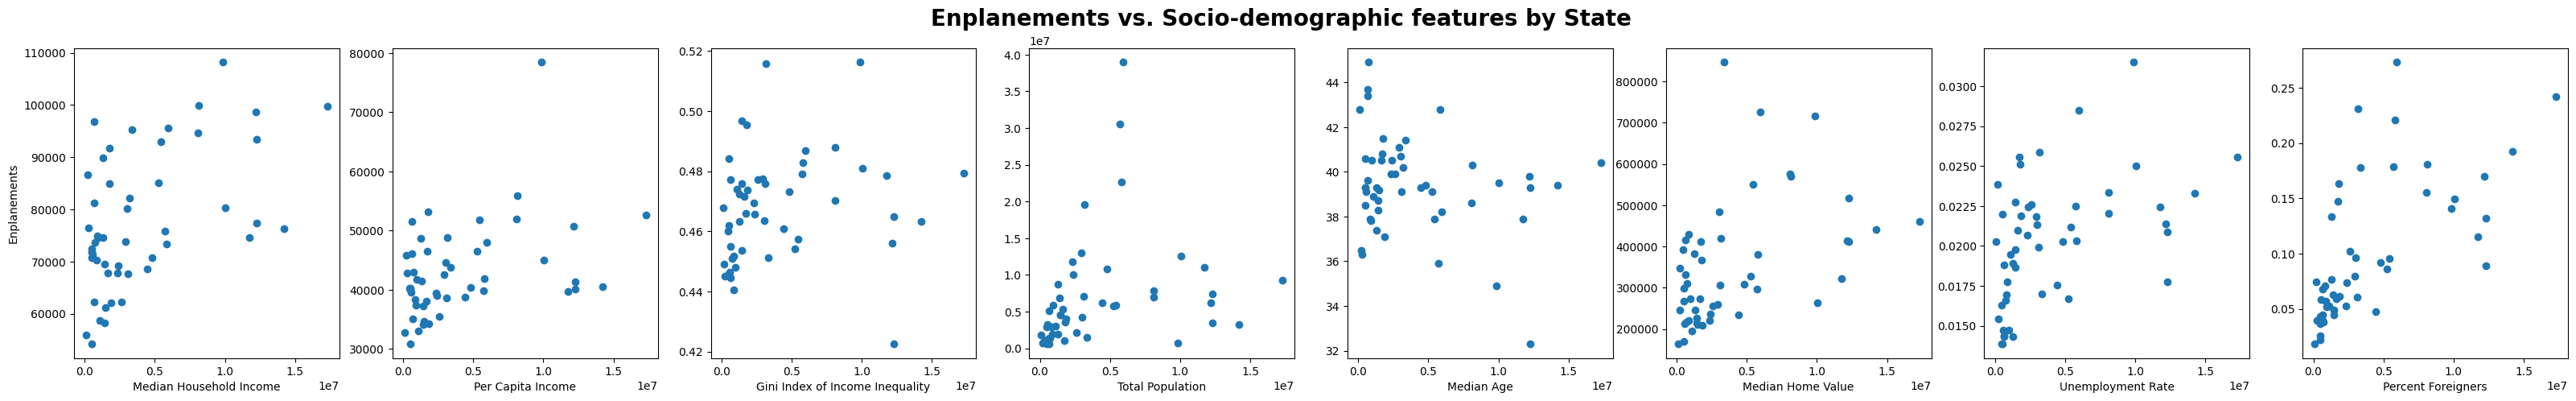

In [285]:
sociodemo_cols = [
    'Median Household Income', 
    'Per Capita Income',
    'Gini Index of Income Inequality',
    'Total Population', 
    'Median Age',
    'Median Home Value', 
    'Unemployment Rate',
    'Percent Foreigners'
    ]

plt.figure(figsize=(5*len(sociodemo_cols), 5))  
for i in range(len(sociodemo_cols)):
    plt.subplot(1,len(sociodemo_cols),i+1)
    plt.scatter(df['Enplanements'],df[sociodemo_cols[i]])
    plt.xlabel(sociodemo_cols[i])
    if i==0:
        plt.ylabel('Enplanements')
    plt.suptitle('Enplanements vs. Socio-demographic features by State', fontsize=20, weight='bold')
plt.savefig('visualizations/enplanements_vs_sociodemographics.png', dpi=300)
plt.show()

- Mainly positive, linear correlations between Enplanements and the selected sociodemographic variables except Median age. --> let's drop median age col from subsequent clustering.
- Most sociodemographic variables appear to be right-skewed

In [286]:
df.drop(columns=['Median Age'],inplace=True)

In [292]:
acs_df.Year.unique()
acs_df.columns

Index(['Median Household Income', 'Per Capita Income',
       'Gini Index of Income Inequality', 'Total Population', 'Median Age',
       'Median Home Value', 'State Code (FIPS)', 'Year', 'Unemployment Rate',
       'Percent Foreigners', 'State Name', 'State Code (USPS)'],
      dtype='object')

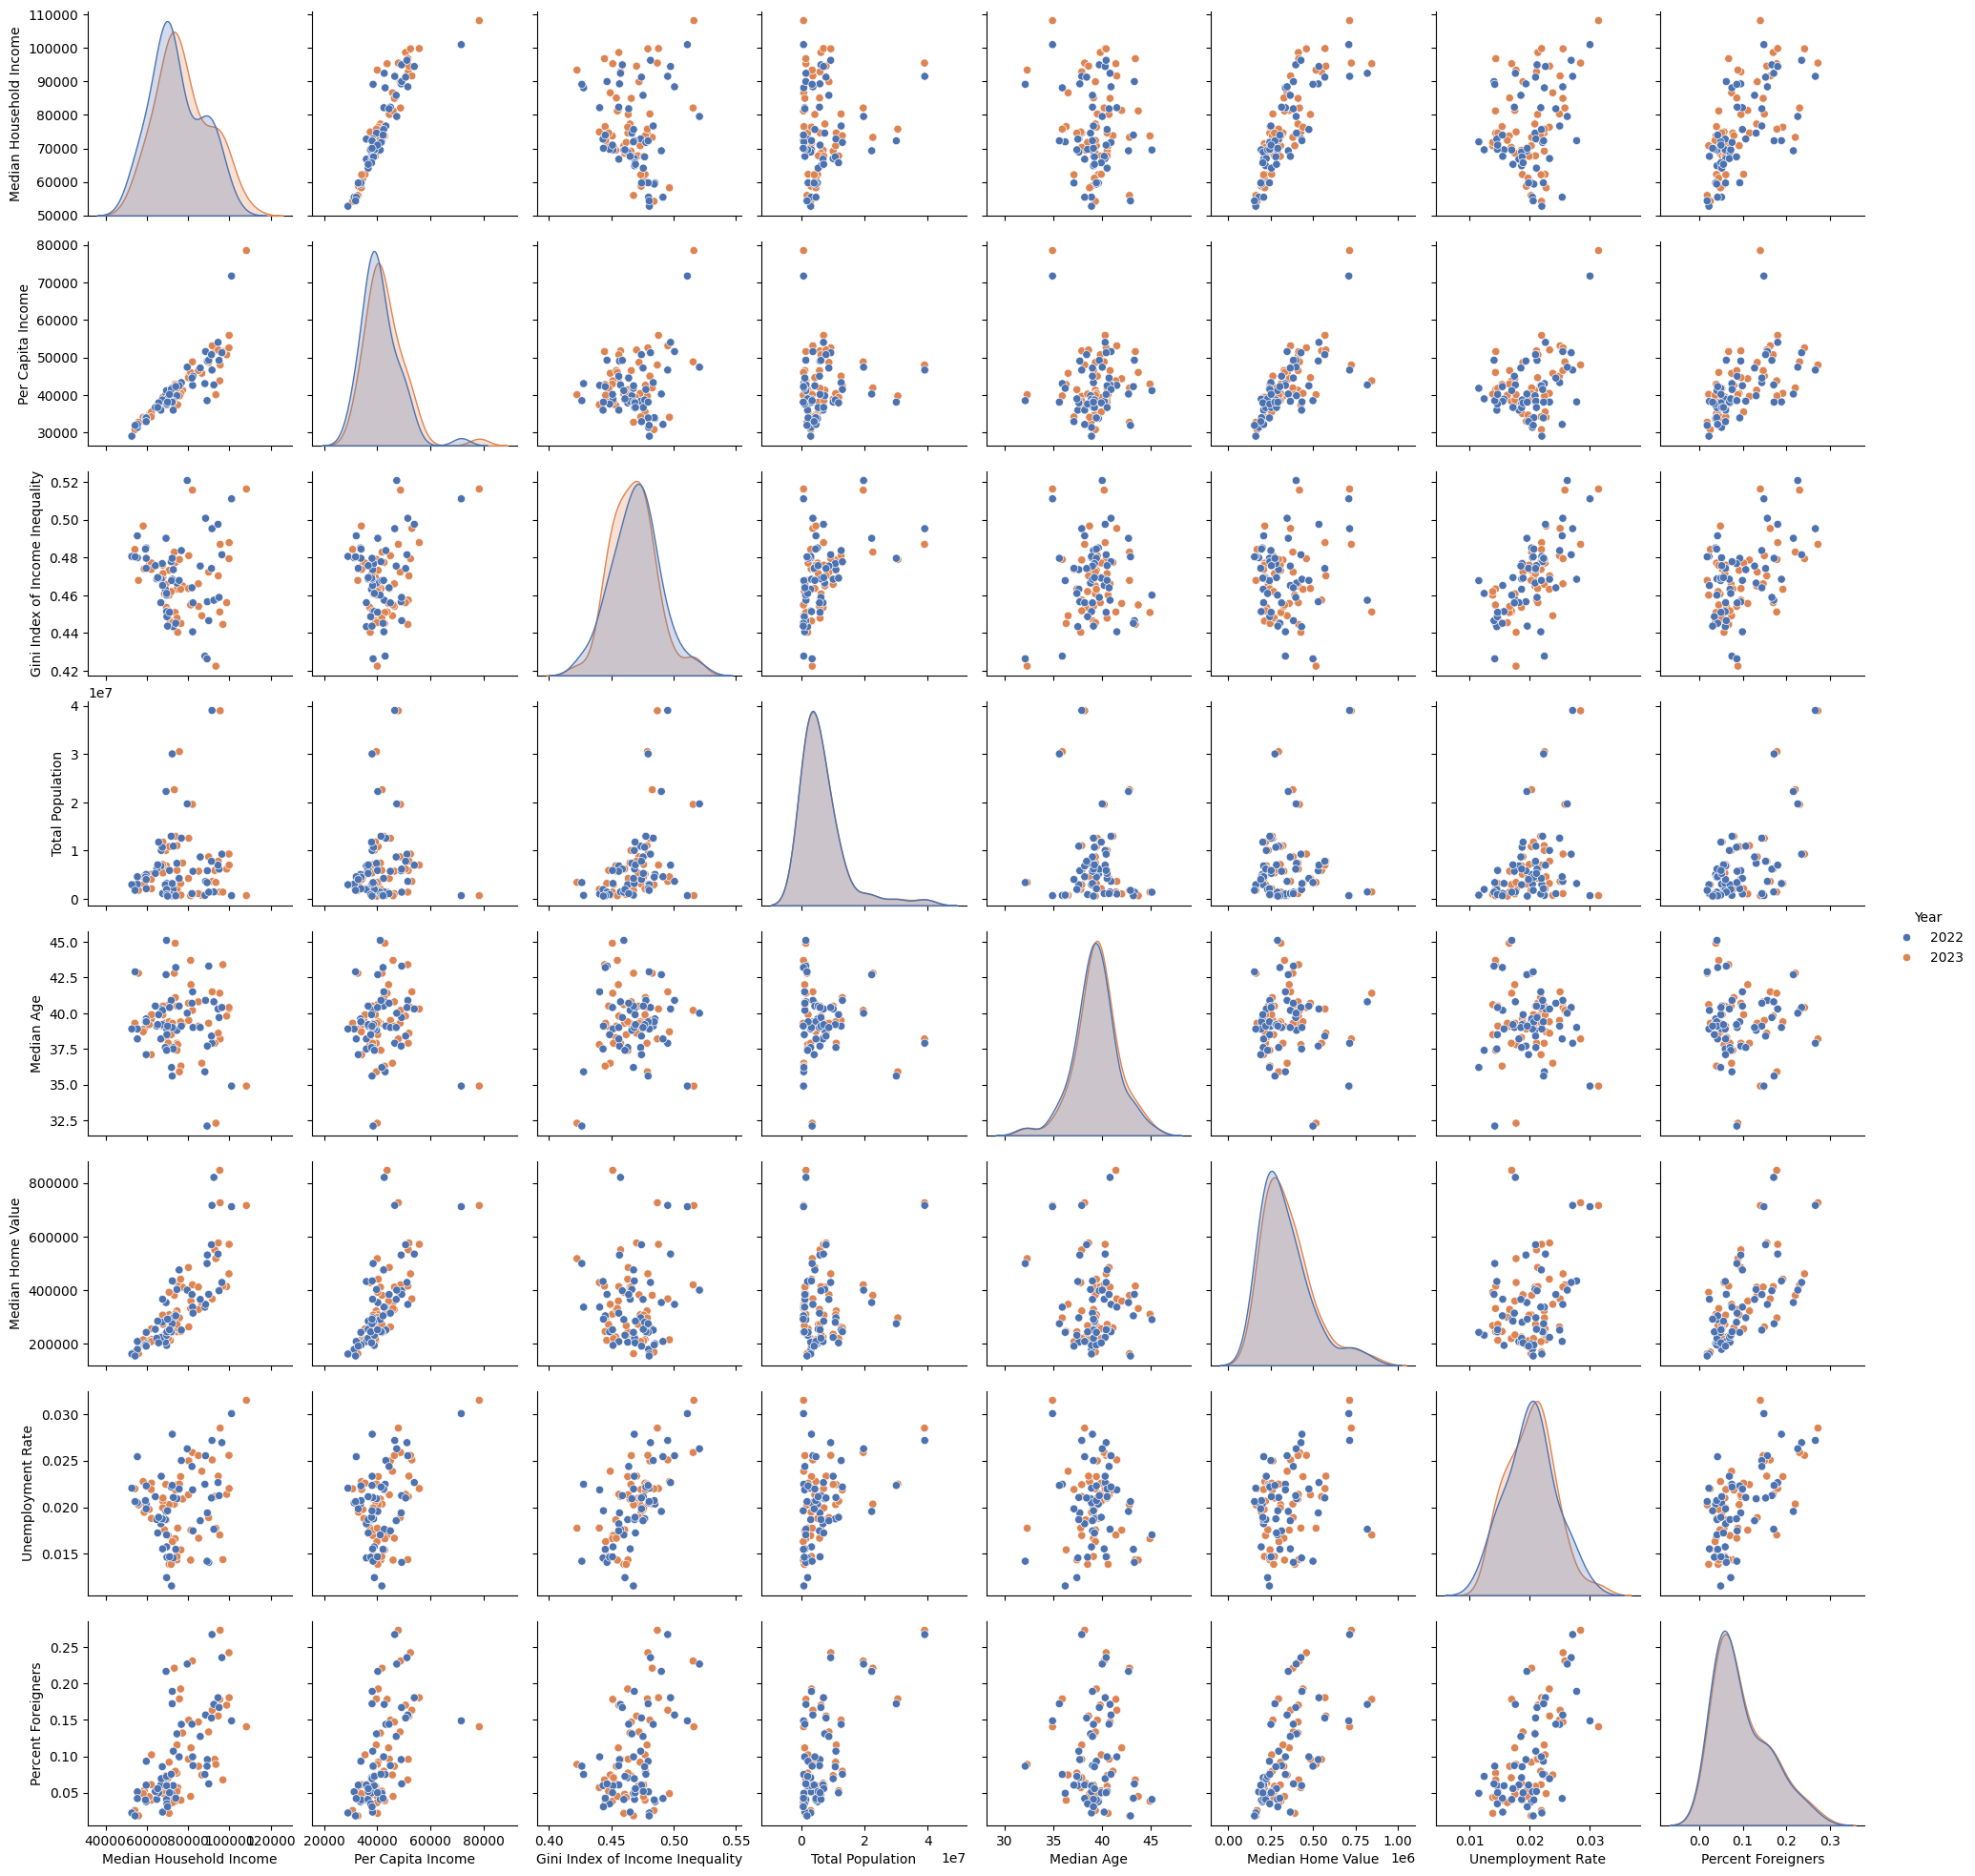

In [294]:
# Create a SPLOM to see the relationships/correlations among Socio-demographic features
# SPLOM for 2022 and 2023 data (SPLOM by year)
img_name = 'acs_SPLOMs_byYear'

tmp = acs_df[[col for col in acs_df.columns if 'State' not in col]].copy()
sns.pairplot(tmp, hue="Year", palette='deep')
plt.savefig(f'visualizations/{img_name}.png', dpi=300)
plt.show()

- Similar distributions for 2022 and 2023. Let's use 2023 for analysis 

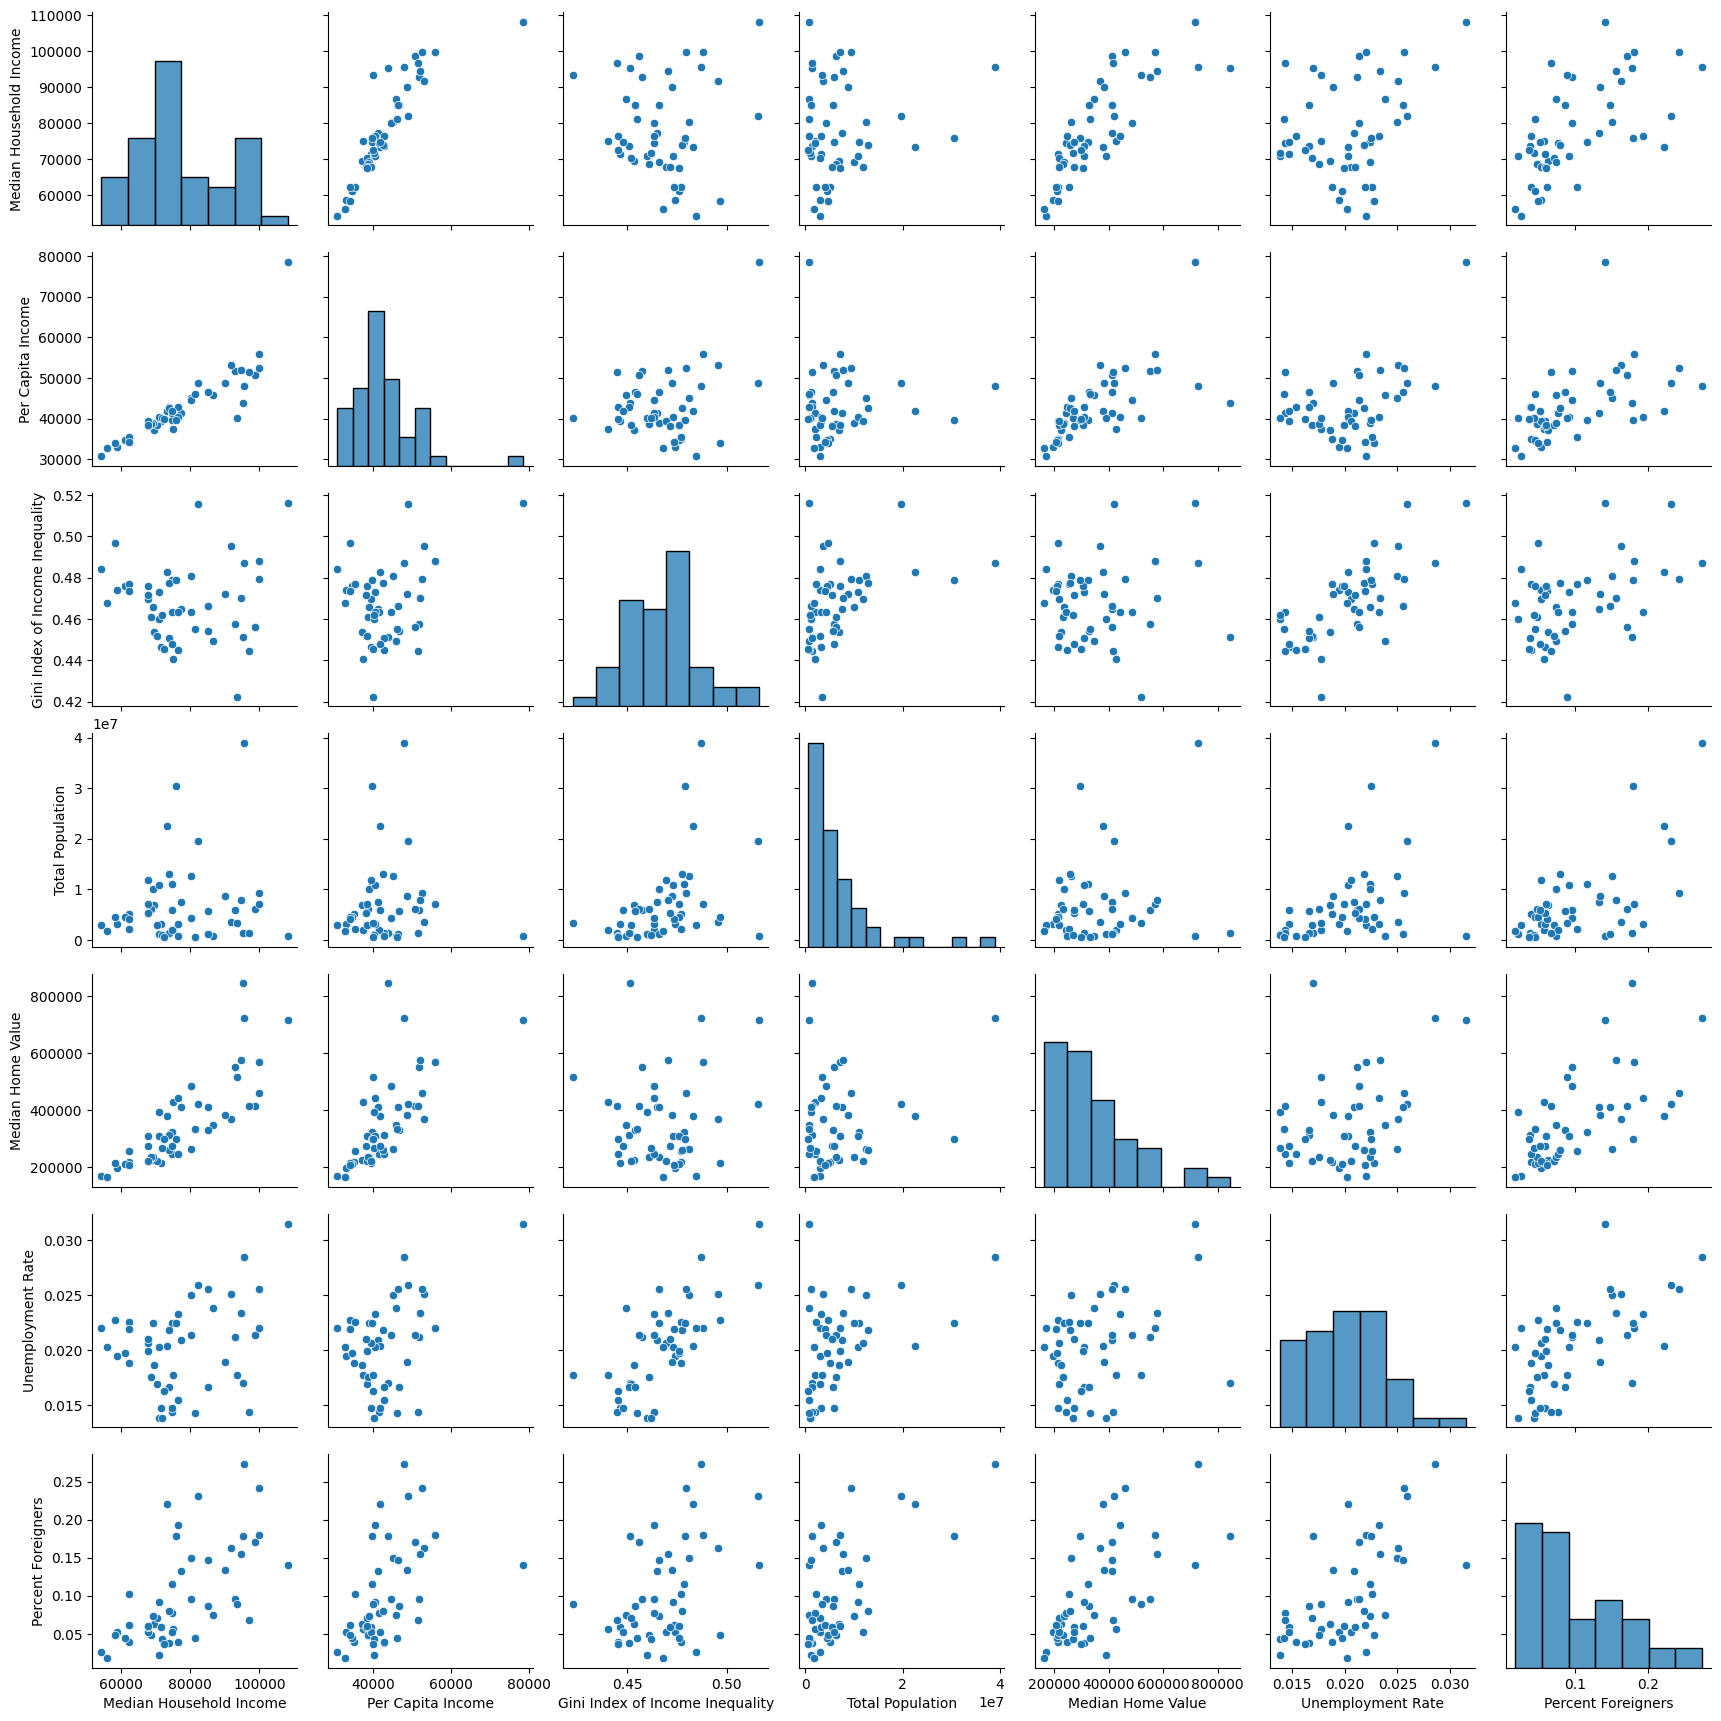

In [289]:
# SPLOM for 2023 data
sns.pairplot(df[[col for col in df.columns if col not in ['Enplanements','Year','State Code (FIPS)']]])
# plt.savefig('visualizations/SPLOM_sociodemographics.png',dpi=300)
plt.show()

In [290]:
# # EDA
# # flight_df[flight_df.isna().any(axis=1)] # Mainly NA for Arrivals column

# numeric_cols = ['Enplanements', 'Passengers', 'Departures', 'Arrivals', 'Freight', 'Mail']
# flight_df_cleaned = flight_df[numeric_cols].dropna()

# # flight_df_cleaned_sample = flight_df_cleaned.sample(100)
# # sns.pairplot(flight_df_cleaned_sample[numeric_cols]) #looks to have outliers (extreme high end), let's use StandardScaler

# flight_df_cleaned_normalized = flight_df_cleaned.copy()
# scaler = StandardScaler()
# flight_df_cleaned_normalized[numeric_cols] = scaler.fit_transform(flight_df_cleaned_normalized[numeric_cols])
# flight_df_cleaned_normalized_sample = flight_df_cleaned_normalized.sample(100)

# # Define temporary df for plotting
# # tmp = flight_df_cleaned_normalized_sample.copy()
# tmp = flight_df_cleaned_normalized.copy()

# # Replot SPLOM
# # sns.pairplot(tmp[numeric_cols]) 
# # plt.savefig('visualizations/flights_sampled100_normalized_SPLOMs.png', dpi=300)
# # plt.show()

# # See the relationship between number of departing passengers vs. departed flights 
# # tmp.plot(x='Departures',y='Enplanements', kind='scatter')
# # plt.savefig('visualizations/flights_normalized_Enplanements_vs_Depatures.png', dpi=300)

# # Load saved SPLOM
# # img_name = 'flights_sampled100_normalized_SPLOMs'
# # img_name = 'flights_normalized_Enplanements_vs_Depatures'
# # img = mpimg.imread(f'visualizations/{img_name}.png')
# # plt.imshow(img)
# # plt.axis('off')
# # plt.show()

# Unsupervised Learning

## Dimensionality Reduction

### PCA

In [291]:
df.head()

,State Name,Enplanements,Median Household Income,Per Capita Income,Gini Index of Income Inequality,Total Population,Median Home Value,State Code (FIPS),Year,Unemployment Rate,Percent Foreigners,State Code (USPS)
0,Alabama,6.697678e+05,62212.0,35046.0,0.4771,5108468.0,216600.0,01,2023,0.018804,0.039766,AL
1,Alaska,2.112405e+05,86631.0,45792.0,0.4492,733406.0,347500.0,02,2023,0.023868,0.074408,AK
2,Arizona,1.227266e+07,77315.0,41290.0,0.4650,7431344.0,411200.0,04,2023,0.020882,0.131999,AZ
3,Arkansas,1.096748e+06,58700.0,33012.0,0.4740,3067732.0,195700.0,05,2023,0.019464,0.052919,AR
4,California,5.954076e+06,95521.0,48013.0,0.4870,38965193.0,725800.0,06,2023,0.028509,0.273065,CA


### MDS